In [1]:
import os
import numpy as np
import re
import requests
import tarfile
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import warnings
np.random.seed(0)
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('/content/drive/MyDrive/7.18/all.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/7.18/all.csv'

**table data**

In [3]:
data.head()

,submission_id,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy
0,s694813024,p00000,u706566315,1540908251,Rust,Rust,rs,Wrong Answer,0.0,5012.0,120,0/1
1,s554950692,p00000,u706566315,1540908314,Rust,Rust,rs,Accepted,0.0,5004.0,124,1/1
2,s555203498,p00000,u759934006,1513417513,Rust,Rust,rs,Accepted,0.0,5020.0,136,1/1
3,s309783173,p00000,u233505136,1516826051,Rust,Rust,rs,Accepted,0.0,5004.0,123,1/1
4,s184977351,p00000,u191088660,1517740150,Rust,Rust,rs,Accepted,0.0,5004.0,122,1/1


In [4]:
data=data.query('accuracy=="1/1"&status=="Accepted"')

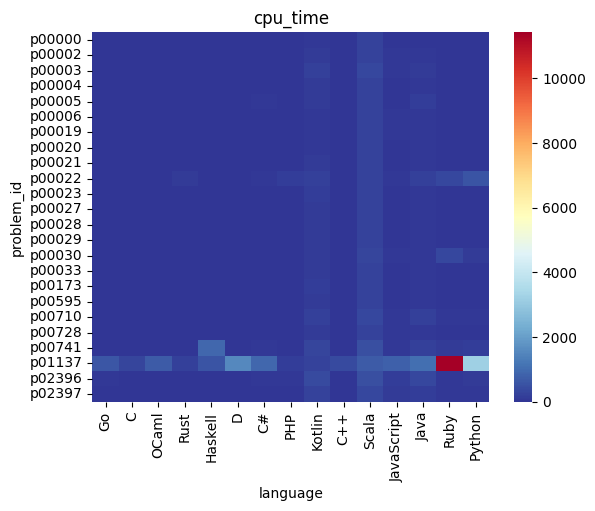

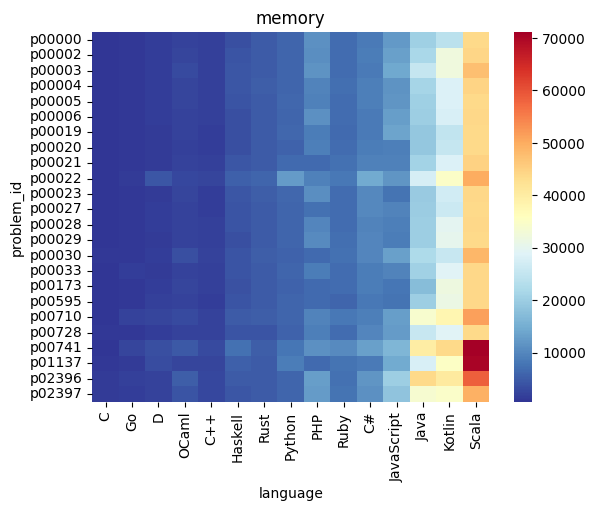

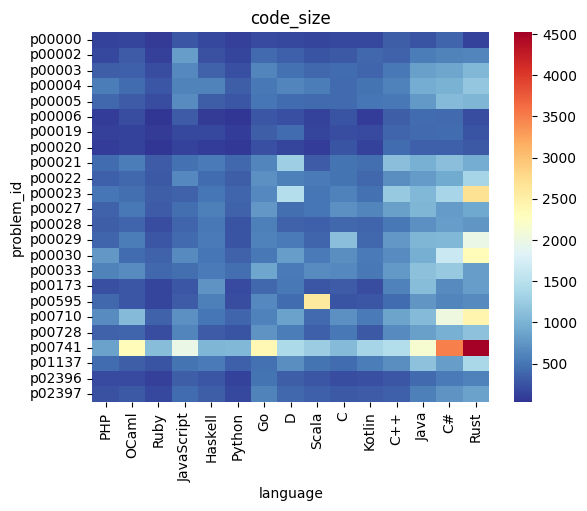

In [5]:
ct=pd.crosstab(data['problem_id'],data['language'],values=data['code_size'],aggfunc='mean')

for var in ['cpu_time','memory','code_size']:
    ct=pd.crosstab(data['problem_id'],data['language'],values=data[var],aggfunc='mean')
    rank=ct.mean().sort_values().index
    ct=ct.loc[:,rank]
    sns.heatmap(ct.dropna(),cmap='RdYlBu_r')
    plt.title(var)
    plt.show()

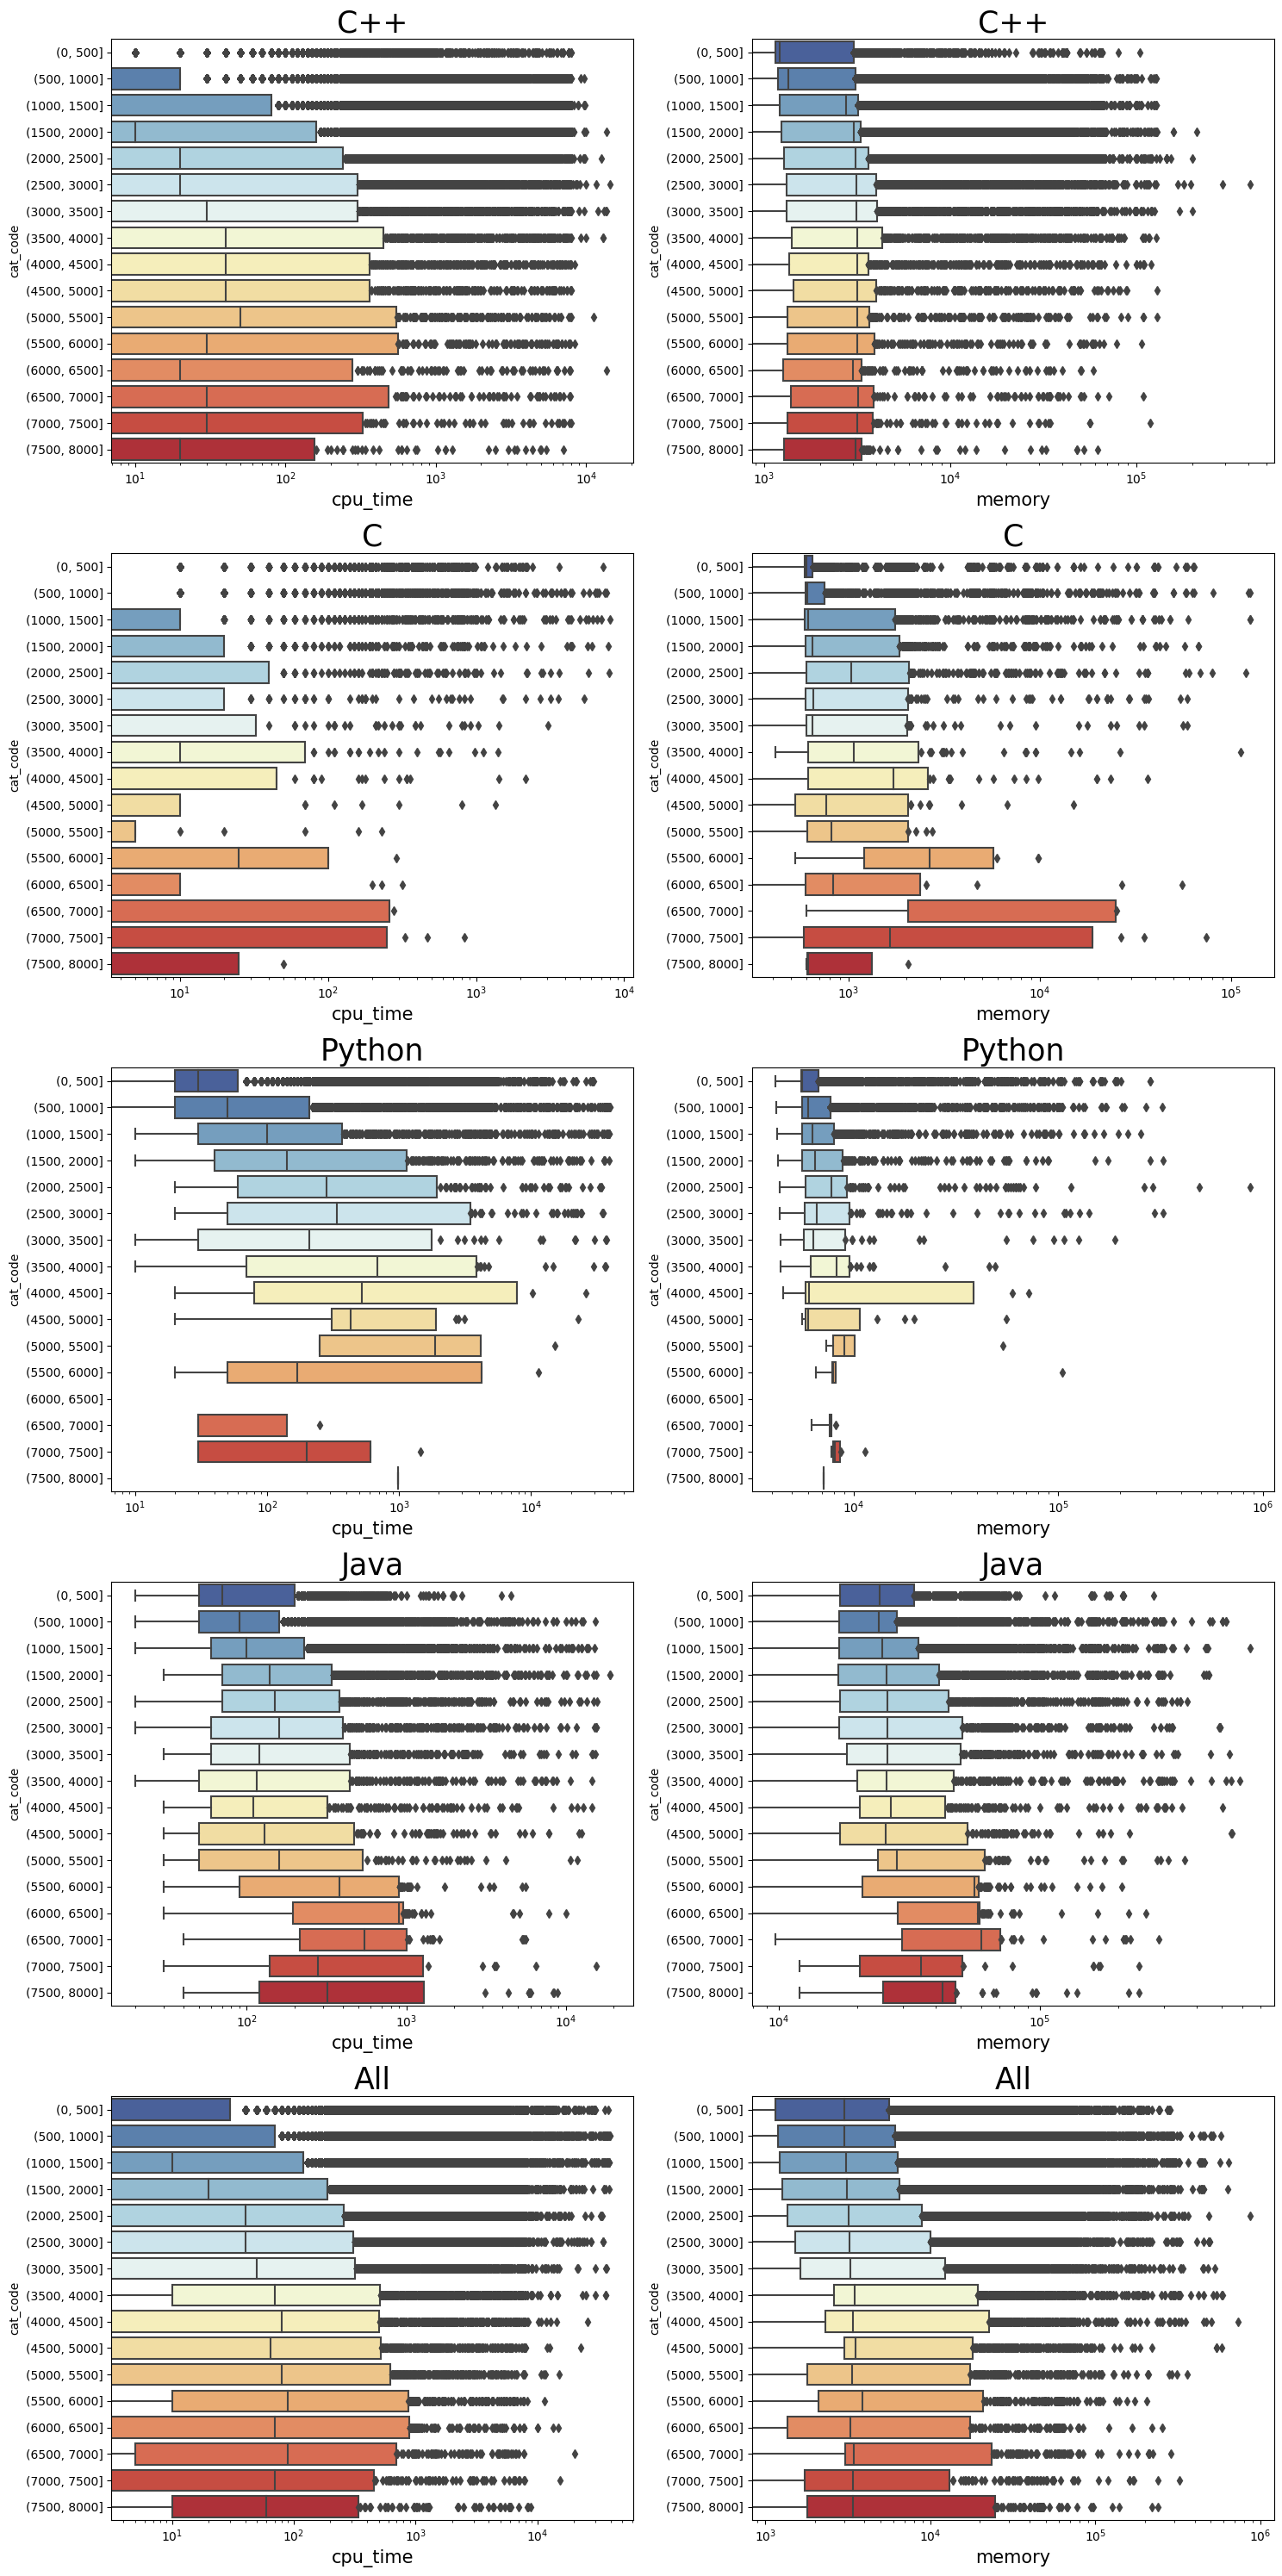

In [6]:
array=np.arange(0,8500,500)
data['cat_code']=pd.cut(data['code_size'],bins=array)

fig,ax=plt.subplots(5,2,figsize=[15,30])
for row,language in enumerate(['C++','C','Python','Java','All']):
    for col,variable in enumerate(['cpu_time','memory']):
        if language!='All':
            df=data.query('language=="{}"'.format(language))
        else:
            df=data
        sns.boxplot(data=df,y='cat_code',x=variable,ax=ax[row,col],palette='RdYlBu_r',whis=[0,50])
        ax[row,col].set_xscale('log')
        ax[row,col].set_xlabel(variable,fontsize=15)
        ax[row,col].set_title(language,fontsize=25)
plt.tight_layout()
plt.savefig('logscale.png',dpi=600, bbox_inches='tight')
plt.show()

In [7]:
languages=['C++','C','Python','Java','All']
data=data[data['language'].isin(languages)]

In [8]:
from scipy.stats import f_oneway

pt=data.pivot_table(index='problem_id',columns='language',aggfunc='mean')
pt.dropna(inplace=True)

for var in ['cpu_time','memory','code_size']:
    df=pt[var].reset_index()
    reshaped_data = pd.melt(df, id_vars=['problem_id'], value_vars=['C', 'C++', 'Java', 'Python'],
                        var_name='language', value_name=var)

    # Perform ANOVA
    f_statistic, p_value = f_oneway(
        reshaped_data[reshaped_data['language'] == 'C'][var],
        reshaped_data[reshaped_data['language'] == 'C++'][var],
        reshaped_data[reshaped_data['language'] == 'Java'][var],
        reshaped_data[reshaped_data['language'] == 'Python'][var]
    )
    print('Var:{},F_statistic:{:.3f}, P_value: {:.3f}'.format(var,f_statistic, p_value))
#这里3个变量的p值都小于0.05 所以我们可以拒绝零假设，认为不同的编程语言对于同一个问题ID的三个变量存在显著差异

Var:cpu_time,F_statistic:60.676, P_value: 0.000
Var:memory,F_statistic:243.444, P_value: 0.000
Var:code_size,F_statistic:105.675, P_value: 0.000


In [9]:
data=data[(data.loc[:,['cpu_time','memory']]>0).all(1)]

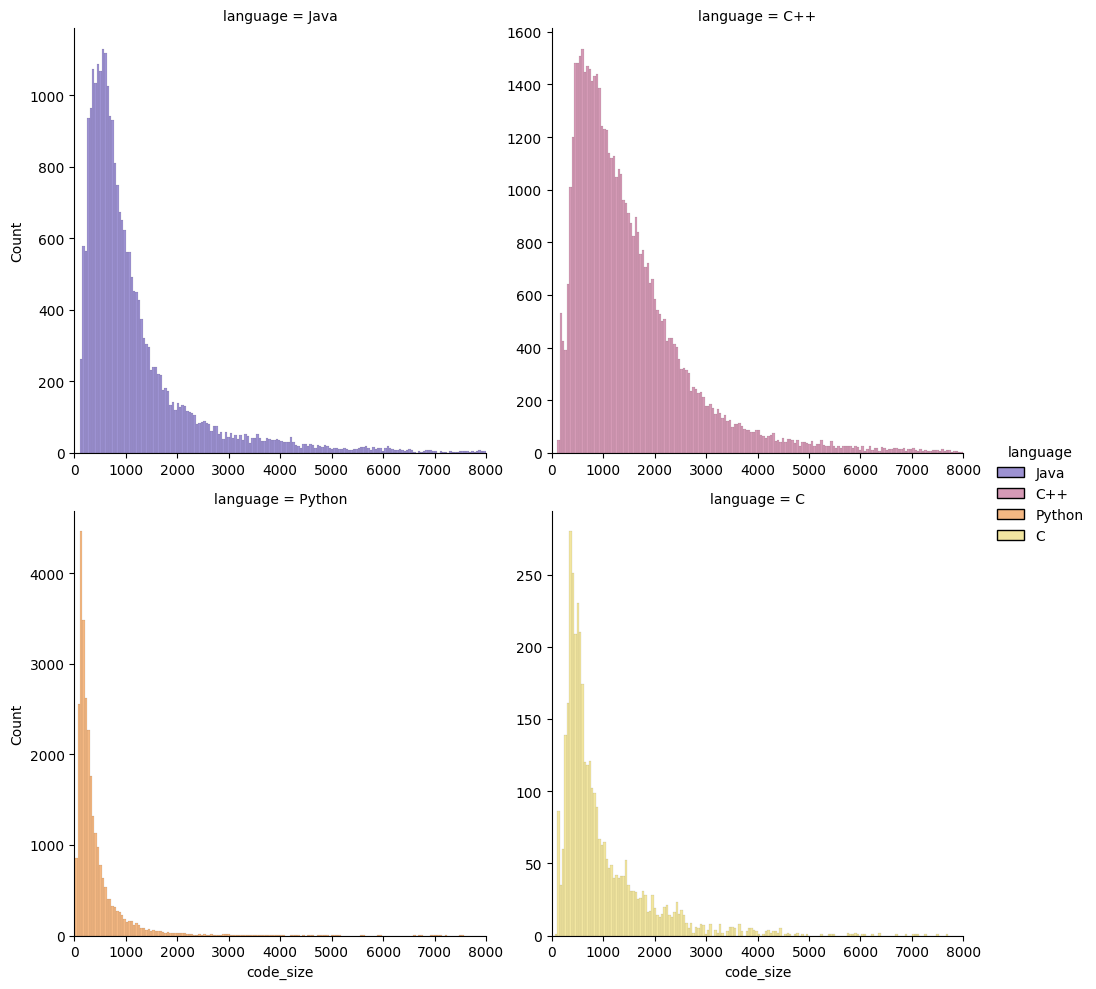

In [10]:
g=sns.displot(data=data,x='code_size',#不同语言的codesize 分布情况
        col='language',
        col_wrap=2,
        facet_kws={'sharex': False,'sharey':False},
        hue='language',
        palette='CMRmap'
        )
for ax in g.axes.flat:
  ax.set_xlim(0,8000)
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,cross_val_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [12]:
linear_param={'fit_intercept':[True,False]}

mlp_param = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

rf_param = {
    'n_estimators': [10, 50],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [2,4,6,8,10],
    'bootstrap': [True, False]
}

gbm_param = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

gbdt_param = {'n_estimators':[100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth':[4, 6, 8],
            'min_samples_leaf':[3, 5, 9, 14],
            'max_features':[0.1, 0.3, 1.0]}

In [13]:
class Model:

  def __init__(self,threshold):
    '''
    threshold：0~1之间的浮点数 如果R2 score高于threshold，结果将被高亮。
    '''
    self.threshold=threshold


  def highlight_greaterthan(self,score,color='orange'):
    return 'background-color: {}'.format(color) if score > self.threshold else ''

  def cv(self,df,reg,parameters):#5折交叉验证
    size=len(df)

    if size<20:
        return pd.DataFrame([[0,0,0,0,0]],columns=['code_cpu','code_memory','code+memory_cpu','code+cpu_memory','size'])
    result=[]
    for pair in [
        [['code_size'],'cpu_time'],
        [['code_size'],'memory'],
        [['code_size','memory'],'cpu_time'],
        [['code_size','cpu_time'],'memory']
        ]:
        features=df[pair[0]]
        gs=GridSearchCV(reg(),param_grid=parameters,scoring='r2',n_jobs=4,pre_dispatch=4)
        gs.fit(features,df[pair[1]])
        result.append(gs.best_score_)
    result.append(size)
    return pd.DataFrame([result],columns=['code_cpu','code_memory','code+memory_cpu','code+cpu_memory','size'])

  def run(self,data,reg,language,bins,parameters={}):
    '''
    data:dataframe 整体数据
    language:str 选中的编程语言
    bins:list 分段规则 例如[0,1000,3000,10000]
    '''
    sub=data.query('language=="{}"'.format(language))
    sub['category']=pd.cut(sub['code_size'],bins=bins).astype(str)
    cv_result=sub.groupby(['category']).apply(lambda df:self.cv(df,reg,parameters))
    cv_result.sort_index(inplace=True)
    result=cv_result[(cv_result>0.6).any(1)].style.applymap(lambda score:self.highlight_greaterthan(score))
    return result

In [14]:
model=Model(threshold=0.6)

**<h3>Languages and Bins<h3>**

In [15]:
language='Java'#需要建模的语言
bins=[0,1000,2000,4000,10000]#code size 分段方式 如果想修改 请改这里

**linear**

In [16]:
model.run(data=data,
     language=language,#需要建模的语言
     reg=LinearRegression,#使用的模型
     bins=bins,#code size 分段方式
     parameters=linear_param)#交叉验证使用的优化参数，如果不填 则默认只做交叉验证。
#结果的nan是bins最大范围之外的数据

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
category,,,,,,
"(0, 1000]",0,-0.333318,-0.790509,-0.133144,-0.554421,16230
"(1000, 2000]",0,-1.198424,-0.551932,-0.440111,-0.310769,6359
"(2000, 4000]",0,-7.375012,-2.025578,-3.290109,-1.239651,2748
"(4000, 10000]",0,-2.164320,-0.584476,-0.679590,-0.186080,1128
nan,0,-0.322932,-0.694445,-0.591693,-2.405565,161


**RandomForest**

In [17]:
model.run(data=data,
     language=language,#需要建模的语言
     reg=RandomForestRegressor,#使用的模型
     bins=bins,#code size 分段方式
    #  parameters=rf_param
     #交叉验证使用的优化参数，如果不填 则默认只做交叉验证。
     )

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
category,,,,,,
"(0, 1000]",0,-0.802410,-1.163493,-1.369041,-0.197996,16230
"(1000, 2000]",0,-3.945852,-1.482649,-2.185293,-0.023394,6359
"(2000, 4000]",0,-24.432244,-6.685016,-5.695572,0.090027,2748
"(4000, 10000]",0,-16.300511,-4.270669,-3.749884,-0.124864,1128
nan,0,-5.770224,-3.408424,-2.902009,-0.501873,161


**MLP**

In [18]:
model.run(data=data,
     language=language,#需要建模的语言
     reg=MLPRegressor,#使用的模型
     bins=bins,#code size 分段方式
    #  parameters=mlp_param
     #交叉验证使用的优化参数，如果不填 则默认只做交叉验证。
     )

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
category,,,,,,
"(0, 1000]",0,-0.503499,-1.276228,-0.126613,-0.624921,16230
"(1000, 2000]",0,-1.248997,-0.546572,-0.457799,0.200131,6359
"(2000, 4000]",0,-7.391498,-2.052253,-2.683785,-0.029999,2748
"(4000, 10000]",0,-2.307250,-0.584298,-0.968465,-0.130343,1128
nan,0,-1.102305,-0.286778,-9.649070,-0.227089,161


**Lightgbm**

In [19]:
model.run(data=data,
     language=language,#需要建模的语言
     reg=LGBMRegressor,#使用的模型
     bins=bins,#code size 分段方式
    #  parameters=gbm_param
     #交叉验证使用的优化参数，如果不填 则默认只做交叉验证。
     )

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
category,,,,,,
"(0, 1000]",0,-0.540200,-0.912313,-0.148982,0.037572,16230
"(1000, 2000]",0,-1.631040,-0.655499,-0.993298,0.103358,6359
"(2000, 4000]",0,-12.516018,-2.923624,-4.532068,0.149648,2748
"(4000, 10000]",0,-4.636754,-1.864165,-2.671059,-0.081541,1128
nan,0,-0.862387,-1.508691,-0.403973,-0.420037,161


**GBDT**

In [20]:
model.run(data=data,
     language=language,#需要建模的语言
     reg=GradientBoostingRegressor,#使用的模型
     bins=bins,#code size 分段方式
    #  parameters=gbm_param
     #交叉验证使用的优化参数，如果不填 则默认只做交叉验证。
     )

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
category,,,,,,
"(0, 1000]",0,-0.523334,-0.835772,-0.084028,-0.397740,16230
"(1000, 2000]",0,-1.388113,-0.620905,-0.634488,0.157393,6359
"(2000, 4000]",0,-13.763214,-3.098485,-3.559459,0.170941,2748
"(4000, 10000]",0,-10.594381,-2.307174,-3.243167,-0.052972,1128
nan,0,-10.667163,-3.900526,-4.830926,-0.590113,161
